In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [3]:
all_data = pd.read_csv('gamelvl_joined.csv')
all_data.head()

,Unnamed: 0,year,game_ID,home_numberGame,home_ID_team,home_isB2B,home_isB2BFirst,home_isB2BSecond,home_name,home_countDaysRest,...,away_points,away_plusminus,away_ind_Win,away_ind_SecondB2B,away_ind_overtime,away_offensive_rating,away_defensive_rating,away_RAPTOR_offensive,away_RAPTOR_defensive,away_RAPTOR_net
0,1,2018,21700002,1,1610612744,False,True,False,GSW,120,...,122,1,1,0,0,114.7,106.1,6.1,2.5,8.7
1,2,2018,21700001,1,1610612739,False,True,False,CLE,120,...,99,-3,0,0,0,107.6,103.9,-1.0,4.7,3.7
2,3,2018,21700010,1,1610612762,False,True,False,UTA,120,...,96,-10,0,0,0,112.5,111.0,3.9,-2.3,1.5
3,4,2018,21700011,1,1610612759,False,False,False,SAS,120,...,99,-8,0,0,0,113.4,111.1,4.8,-2.4,2.3
4,5,2018,21700007,2,1610612738,True,False,True,BOS,0,...,108,8,1,0,0,109.8,110.1,1.2,-1.5,-0.3


In [4]:
#Engineering some new variables that may be useful in predicting spread of NBA games

all_data["spread"] = all_data["home_points"] - all_data["away_points"]
all_data["home_ftr"] = all_data["home_freethrow_attempts"] / all_data["home_fieldgoal_attempts"]
all_data["away_ftr"] = all_data["away_freethrow_attempts"] / all_data["away_fieldgoal_attempts"]
all_data["home_pace"] = (all_data["home_fieldgoal_attempts"] + .44 * all_data["home_freethrow_attempts"] - all_data["home_off_reb"]+all_data["home_turnovers"])/48
all_data["away_pace"] = (all_data["away_fieldgoal_attempts"] + .44 * all_data["away_freethrow_attempts"] - all_data["away_off_reb"]+all_data["away_turnovers"])/48
all_data["home_turnover_rate"] = all_data["home_turnovers"] / (all_data["home_fieldgoal_attempts"] + .44 * all_data["home_freethrow_attempts"] - all_data["home_off_reb"]+all_data["home_turnovers"])
all_data["away_turnover_rate"] = all_data["away_turnovers"] / (all_data["away_fieldgoal_attempts"] + .44 * all_data["away_freethrow_attempts"] - all_data["away_off_reb"]+all_data["away_turnovers"])
all_data["home_atr"] = all_data["home_assists"] / all_data["home_turnovers"]
all_data["away_atr"] = all_data["away_assists"] / all_data["away_turnovers"]
all_data["matchup"] = all_data["away_name"] + " @ " + all_data["home_name"]

dates = pd.read_csv('dates.csv')
dates['game_ID'] = dates['idGame']
dates = dates.drop(columns=['idGame'])
all_data = pd.merge(all_data, dates, on='game_ID', how='inner')
all_data = all_data.rename(columns={'dateGame': 'date'})
all_data.head()

,Unnamed: 0,year,game_ID,home_numberGame,home_ID_team,home_isB2B,home_isB2BFirst,home_isB2BSecond,home_name,home_countDaysRest,...,home_ftr,away_ftr,home_pace,away_pace,home_turnover_rate,away_turnover_rate,home_atr,away_atr,matchup,date
0,1,2018,21700002,1,1610612744,False,True,False,GSW,120,...,0.262500,0.195876,2.088333,2.257500,0.169593,0.119970,2.000000,2.153846,HOU @ GSW,2017-10-17
1,2,2018,21700001,1,1610612739,False,True,False,CLE,120,...,0.301205,0.284091,2.125000,2.125000,0.166667,0.117647,1.117647,2.000000,BOS @ CLE,2017-10-17
2,3,2018,21700010,1,1610612762,False,True,False,UTA,120,...,0.197531,0.155844,2.021667,2.005833,0.154575,0.218114,1.866667,1.000000,DEN @ UTA,2017-10-18
3,4,2018,21700011,1,1610612759,False,False,False,SAS,120,...,0.213483,0.270588,2.007500,2.023333,0.114155,0.133855,2.000000,1.769231,MIN @ SAS,2017-10-18
4,5,2018,21700007,2,1610612738,True,False,True,BOS,0,...,0.230769,0.394737,2.171667,2.045833,0.143899,0.152749,1.533333,1.266667,MIL @ BOS,2017-10-18


In [5]:
def get_averages(year:int):

    all_data_2024 = all_data[all_data['year'] == year]

    # Group by home_name (home team) and calculate the mean across numeric variables, removing NA values
    grouped_by_home = all_data_2024.groupby('home_name').mean()

    # Extract column names containing "home"
    columns_containing_home = [col for col in grouped_by_home.columns if 'home' in col]

    # Select only columns containing "home" to isolate averages when teams are playing at home
    average_values_by_home_team = grouped_by_home[columns_containing_home].reset_index()

    # Repeating but for away
    average_values_by_away_team = all_data_2024.groupby('away_name').mean().dropna()
    away_columns = [col for col in average_values_by_away_team.columns if 'away' in col]
    average_values_by_away_team = average_values_by_away_team[away_columns].reset_index()

    joined_averages = pd.merge(average_values_by_away_team, average_values_by_home_team, how='cross')
    joined_averages = joined_averages[joined_averages['away_name'] != joined_averages['home_name']]
    joined_averages['matchup'] = joined_averages['away_name'] + ' @ ' + joined_averages['home_name']

    # Drop unnecessary columns
    joined_averages = joined_averages.drop(columns=['away_name', 'home_name'])
    return joined_averages.iloc[:]

full_averages_table = pd.DataFrame()
for year in range(2018,2025):
    year_averages = get_averages(year)
    year_averages['year'] = year
    full_averages_table = pd.concat([full_averages_table, year_averages], ignore_index=True)

full_averages_table


,away_numberGame,away_ID_team,away_isB2B,away_isB2BFirst,away_isB2BSecond,away_countDaysRest,away_countDaysNextGame,away_isWin,away_fieldgoal_made,away_fieldgoal_attempts,...,home_defensive_rating,home_RAPTOR_offensive,home_RAPTOR_defensive,home_RAPTOR_net,home_ftr,home_pace,home_turnover_rate,home_atr,matchup,year
0,40.707317,1.610613e+09,0.463415,0.146341,0.170732,4.121951,1.073171,0.195122,37.878049,86.146341,...,110.6,-1.7,-2.0,-3.8,0.268236,2.110163,0.142100,1.676886,ATL @ BKN,2018
1,40.707317,1.610613e+09,0.463415,0.146341,0.170732,4.121951,1.073171,0.195122,37.878049,86.146341,...,103.9,-1.0,4.7,3.7,0.241794,2.067764,0.136055,1.958005,ATL @ BOS,2018
2,40.707317,1.610613e+09,0.463415,0.146341,0.170732,4.121951,1.073171,0.195122,37.878049,86.146341,...,109.1,0.8,-0.5,0.3,0.321661,2.128374,0.131674,1.709707,ATL @ CHA,2018
3,40.707317,1.610613e+09,0.463415,0.146341,0.170732,4.121951,1.073171,0.195122,37.878049,86.146341,...,110.9,-4.9,-2.2,-7.1,0.204270,2.101545,0.133281,1.956472,ATL @ CHI,2018
4,40.707317,1.610613e+09,0.463415,0.146341,0.170732,4.121951,1.073171,0.195122,37.878049,86.146341,...,111.9,4.2,-3.3,1.0,0.279776,2.097012,0.135101,1.868456,ATL @ CLE,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6085,35.000000,1.610613e+09,0.368421,0.184211,0.131579,4.342105,1.210526,0.210526,42.684211,92.631579,...,117.9,-6.6,-2.4,-9.0,0.240264,2.096820,0.146045,1.641533,WAS @ POR,2024
6086,35.000000,1.610613e+09,0.368421,0.184211,0.131579,4.342105,1.210526,0.210526,42.684211,92.631579,...,115.9,1.6,-0.4,1.2,0.246741,2.150768,0.126110,2.522138,WAS @ SAC,2024
6087,35.000000,1.610613e+09,0.368421,0.184211,0.131579,4.342105,1.210526,0.210526,42.684211,92.631579,...,117.3,-5.1,-1.8,-6.9,0.230536,2.162741,0.146028,2.087578,WAS @ SAS,2024
6088,35.000000,1.610613e+09,0.368421,0.184211,0.131579,4.342105,1.210526,0.210526,42.684211,92.631579,...,118.6,-2.6,-3.1,-5.7,0.234390,2.107457,0.138769,2.180957,WAS @ TOR,2024


In [6]:
import requests
from bs4 import BeautifulSoup

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
}
links = [
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2017-18/",
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2018-19/",
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2019-20/",
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2020-21/",
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2021-22/",
    "https://www.sportsbookreviewsonline.com/scoresoddsarchives/nba-odds-2022-23/"
]
def create_ml_table(link:str, year:int):
    page = requests.get(link, headers= headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    table = soup.find('table', class_ = "table bg-white table-hover table-bordered table-sm")
    df = pd.DataFrame(columns = ['Date', 'Rot', 'VH', 'Team', '1st', '2nd', '3rd', '4th', 'Final', 'Open', 'Close', 'ML', '2H'])
    for row in table.find_all('tr'):
        data = []
        for cell in row.find_all('td'):
            data.append(cell.text.strip())
        if len(data) == len(df.columns):
            df.loc[len(df)] = data
    df = df.drop(df.index[0])
    # if df['Date'][:2] in ['10', '11', '12']:
    #     df['year'] = year
    # else:
    #     df['year'] = year+1
    df['year'] = year
    return df
year = 2017
ml_table= pd.DataFrame()
for link in links:
    ml_table = pd.concat([ml_table, create_ml_table(link, year)], ignore_index=True)
    year+=1
ml_table = ml_table[ml_table['VH'] == 'H'].iloc[:, [0, 3, 11,13]]
for index, row in ml_table.iterrows():
    if len(str(row['Date'])) == 3:
        ml_table.loc[index, 'year'] += 1


In [7]:
# Assuming your DataFrame is named 'df' and the date column is named 'date'
ml_table['Date'] = ml_table['Date'].apply(lambda x: '0' + x if len(x) == 3 else x)

ml_table['MM'] = ml_table['Date'].astype(str).str[:2]
ml_table['DD'] = ml_table['Date'].astype(str).str[2:]

# Combine 'year', 'MM', and 'DD' columns to create 'date' column
ml_table['date'] = ml_table['year'].astype(str) + '-' + ml_table['MM'] + '-' + ml_table['DD']

ml_table = ml_table.drop(columns=['year','MM','DD', 'Date'])

team_mapping = {
    "LALakers": "LAL",
    "Boston": "BOS",
    "GoldenState": "GSW",
    "Miami": "MIA",
    "SanAntonio": "SAS",
    "Brooklyn": "BKN",
    "Memphis": "MEM",
    "Detroit": "DET",
    "Toronto": "TOR",
    "Indiana": "IND",
    "Atlanta": "ATL",
    "Minnesota": "MIN",
    "NewYork": "NYK",
    "Washington": "WAS",
    "Phoenix": "PHX",
    "Utah": "UTA",
    "Sacramento": "SAC",
    "Philadelphia": "PHI",
    "Charlotte": "CHA",
    "Houston": "HOU",
    "Portland": "POR",
    "Orlando": "ORL",
    "Chicago": "CHI",
    "Milwaukee": "MIL",
    "Dallas": "DAL",
    "Denver": "DEN",
    "NewOrleans": "NOP",
    "Cleveland": "CLE",
    "OklahomaCity": "OKC",
    "LAClippers": "LAC"
}
ml_table['home_name'] = ml_table['Team'].map(team_mapping)
ml_table = ml_table.drop(columns=['Team'])


ml_table

,ML,date,home_name
1,-195,2017-10-17,CLE
3,-470,2017-10-17,GSW
5,-155,2017-10-18,IND
7,-300,2017-10-18,WAS
9,145,2017-10-18,ORL
...,...,...,...
13841,120,2023-01-16,WAS
13843,-115,2023-01-16,ATL
13845,-175,2023-01-16,MIN
13847,-800,2023-01-16,MEM


In [8]:
final_table = all_data
final_table = final_table.iloc[:,[94,1,93,84]]
final_table = pd.merge(final_table, full_averages_table, on=['year', 'matchup'], how='inner')
final_table = final_table.iloc[:, 0:4].join(final_table.iloc[:,final_table.columns.get_loc("away_fieldgoal_made"):final_table.columns.get_loc("away_points")]
                                            ).join(final_table.iloc[:,final_table.columns.get_loc("away_offensive_rating"):final_table.columns.get_loc("away_atr")+1]
                                                   ).join(final_table.iloc[:,final_table.columns.get_loc("home_fieldgoal_made"):final_table.columns.get_loc("home_points")]
                                                          ).join(final_table.iloc[:,final_table.columns.get_loc("home_offensive_rating"):])
final_table['home_name'] = final_table['matchup'].str.split(' @ ').str[1]
#final_table = pd.merge(final_table, ml_table, on=['date', 'home_name'], how='inner')
final_table

,date,year,matchup,spread,away_fieldgoal_made,away_fieldgoal_attempts,away_fieldgoal_percent,away_fieldgoal3_made,away_fieldgoal3_attempts,away_fieldgoal3_percent,...,home_offensive_rating,home_defensive_rating,home_RAPTOR_offensive,home_RAPTOR_defensive,home_RAPTOR_net,home_ftr,home_pace,home_turnover_rate,home_atr,home_name
0,2017-10-17,2018,HOU @ GSW,-1,38.195122,83.707317,0.456976,15.170732,41.317073,0.368837,...,113.6,107.6,5.0,1.0,6.0,0.225935,2.075711,0.157353,2.059939,GSW
1,2017-10-17,2018,BOS @ CLE,3,37.512195,84.121951,0.446634,11.536585,29.975610,0.389539,...,112.9,111.9,4.2,-3.3,1.0,0.279776,2.097012,0.135101,1.868456,CLE
2,2017-10-18,2018,DEN @ UTA,10,40.341463,87.243902,0.462951,11.609756,31.073171,0.367685,...,108.4,103.9,-0.2,4.7,4.5,0.272196,2.038354,0.149927,1.645044,UTA
3,2017-11-28,2018,DEN @ UTA,29,40.341463,87.243902,0.462951,11.609756,31.073171,0.367685,...,108.4,103.9,-0.2,4.7,4.5,0.272196,2.038354,0.149927,1.645044,UTA
4,2017-10-18,2018,MIN @ SAS,8,40.195122,85.219512,0.473098,7.682927,21.731707,0.352442,...,107.9,104.8,-0.7,3.8,3.0,0.237277,2.020569,0.135083,1.992707,SAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8193,2024-04-03,2024,POR @ CHA,-3,39.052632,88.473684,0.442237,11.473684,33.131579,0.346603,...,109.0,119.9,-6.4,-4.4,-10.9,0.225172,2.079342,0.133990,2.071946,CHA
8194,2024-04-03,2024,CLE @ PHX,21,40.743590,86.102564,0.473359,12.923077,36.256410,0.352390,...,118.1,115.3,2.6,0.2,2.8,0.301574,2.110658,0.146186,1.973458,PHX
8195,2024-04-03,2024,ORL @ NOP,-9,39.486486,84.567568,0.467622,11.081081,31.216216,0.353049,...,117.4,112.6,2.0,2.8,4.8,0.268686,2.102544,0.125708,2.335677,NOP
8196,2024-04-03,2024,MEM @ MIL,-10,39.025000,88.650000,0.440625,13.150000,38.050000,0.345869,...,119.2,115.7,3.7,-0.3,3.5,0.272237,2.157785,0.125322,2.320365,MIL


In [9]:
merged_table = pd.merge(final_table, ml_table, on=['date', 'home_name'], how='inner')
merged_table = merged_table.drop(columns=['home_name'])
merged_table

,date,year,matchup,spread,away_fieldgoal_made,away_fieldgoal_attempts,away_fieldgoal_percent,away_fieldgoal3_made,away_fieldgoal3_attempts,away_fieldgoal3_percent,...,home_offensive_rating,home_defensive_rating,home_RAPTOR_offensive,home_RAPTOR_defensive,home_RAPTOR_net,home_ftr,home_pace,home_turnover_rate,home_atr,ML
0,2017-10-17,2018,HOU @ GSW,-1,38.195122,83.707317,0.456976,15.170732,41.317073,0.368837,...,113.6,107.6,5.0,1.0,6.0,0.225935,2.075711,0.157353,2.059939,-470
1,2017-10-17,2018,BOS @ CLE,3,37.512195,84.121951,0.446634,11.536585,29.975610,0.389539,...,112.9,111.9,4.2,-3.3,1.0,0.279776,2.097012,0.135101,1.868456,-195
2,2017-10-18,2018,DEN @ UTA,10,40.341463,87.243902,0.462951,11.609756,31.073171,0.367685,...,108.4,103.9,-0.2,4.7,4.5,0.272196,2.038354,0.149927,1.645044,-140
3,2017-11-28,2018,DEN @ UTA,29,40.341463,87.243902,0.462951,11.609756,31.073171,0.367685,...,108.4,103.9,-0.2,4.7,4.5,0.272196,2.038354,0.149927,1.645044,-105
4,2017-10-18,2018,MIN @ SAS,8,40.195122,85.219512,0.473098,7.682927,21.731707,0.352442,...,107.9,104.8,-0.7,3.8,3.0,0.237277,2.020569,0.135083,1.992707,-125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6398,2023-01-15,2023,ORL @ DEN,3,39.560976,86.707317,0.457463,10.390244,31.804878,0.330344,...,117.6,114.2,2.7,0.6,3.4,0.279607,2.113841,0.139419,2.194373,-550
6399,2023-01-16,2023,IND @ MIL,13,41.048780,88.463415,0.465195,13.170732,35.975610,0.365247,...,115.4,111.9,0.6,2.9,3.6,0.254704,2.147846,0.139086,1.929960,-200
6400,2023-01-16,2023,GSW @ WAS,-9,42.658537,89.536585,0.477610,16.170732,42.658537,0.378577,...,114.4,115.6,-0.4,-0.8,-1.2,0.242169,2.117134,0.139742,2.015015,120
6401,2023-01-16,2023,NOP @ CLE,10,42.219512,88.512195,0.478683,10.341463,29.317073,0.348458,...,116.1,110.6,1.3,4.2,5.6,0.272039,2.067825,0.139138,1.966448,-300


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


predictors = merged_table.columns[4:]
results = {}

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, min_samples_split=100)

# X represents the features and y represents the spread
X = merged_table[predictors]
y = merged_table['spread']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train, y_train)

rf_preds = model.predict(X_test)

random_forest_mae = mean_absolute_error(y_test, rf_preds)
print("Random Forest MAE: ", random_forest_mae)

# Perform cross-validation
scores_rf = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores_rf)
print("Mean Score:", scores_rf.mean() * -1)
results["Random Forests"] = scores_rf.mean() * -1


Random Forest MAE:  10.479289486875341
Cross-Validation Scores: [ -9.47248376  -9.81889596 -10.19826882 -10.67782589 -10.07748698]
Mean Score: 10.048992279653927


In [12]:
from statsmodels.tsa.arima.model import ARIMA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model_ts = ARIMA(y_train, order=(5,1,0))
model_fit = model_ts.fit()

ts_preds = model_fit.forecast(steps=len(y_test))
ts_mae = mean_absolute_error(y_test, ts_preds)
print("Time Series MAE: ", ts_mae)

#scores_ts = cross_val_score(model_ts, X, y, cv=5, scoring='neg_mean_absolute_error')
#print("Cross-Validation Scores:", scores_ts)
#print("Mean Score:", scores_ts.mean() * -1)
#results["Time Series"] = scores_ts.mean() * -1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time Series MAE:  11.649491252074027


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model_2 = LinearRegression()
model_2.fit(X_train, y_train)

linear_reg_preds = model_2.predict(X_test)

lin_mae = mean_absolute_error(y_test, linear_reg_preds)
print("Linear Regression Mean Absolute Error:", lin_mae)

# Perform cross-validation
scores_lin_reg = cross_val_score(model_2, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validation scores_lin_reg
print("Cross-Validation scores_lin_reg:", scores_lin_reg)
print("Mean Score:", scores_lin_reg.mean() * -1)
results["Linear Regression"] = scores_lin_reg.mean() * -1

Linear Regression Mean Absolute Error: 10.147918871988992
Cross-Validation scores_lin_reg: [ -9.55008693  -9.759188   -10.17202438 -10.74377779 -10.11276075]
Mean Score: 10.067567569276536


In [14]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model_3 = Ridge()
model_3.fit(X_train, y_train)

ridge_reg_preds = model_3.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_reg_preds)
print("Ridge Regression Mean Absolute Error:", ridge_mae)

# Perform cross-validation
scores_ridge_reg = cross_val_score(model_3, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validation scores_ridge_reg
print("Cross-Validation scores_ridge_reg:", scores_ridge_reg)
print("Mean Score:", scores_ridge_reg.mean() * -1)
results["Ridge Regression"] = scores_ridge_reg.mean() * -1

Ridge Regression Mean Absolute Error: 10.04190046484949
Cross-Validation scores_ridge_reg: [ -9.52509239  -9.75561378 -10.15388513 -10.68805615 -10.10557561]
Mean Score: 10.045644611378588


In [15]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model_4 = tree.DecisionTreeRegressor()
model_4.fit(X_train, y_train)

tree_preds = model_4.predict(X_test)

tree_mae = mean_absolute_error(y_test, tree_preds)
print("Decision Tree Mean Absolute Error:", tree_mae)

# Perform cross-validation
scores_dt = cross_val_score(model_4, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validation scores_dt
print("Cross-Validation scores_dt:", scores_dt)
print("Mean Score:", scores_dt.mean() * -1)
results["Decision Tree"] = scores_dt.mean() * -1

Decision Tree Mean Absolute Error: 14.769711163153787
Cross-Validation scores_dt: [-15.28376269 -14.95706479 -15.18813427 -15.84804687 -15.48515625]
Mean Score: 15.352432974726776


In [16]:
from sklearn import neural_network
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model_5 = neural_network.MLPRegressor()
model_5.fit(X_train, y_train)

neural_net_preds = model_5.predict(X_test)

neural_net_mae = mean_absolute_error(y_test, neural_net_preds)
print("Neural Network Mean Absolute Error:", neural_net_mae)

# Create an instance of the LinearRegression model
linear_regression = LinearRegression()

# Perform cross-validation
scores_nn = cross_val_score(model_5, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the cross-validation scores_nn
print("Cross-Validation scores_nn:", scores_nn)
print("Mean Score:", scores_nn.mean() * -1)
results["Neural Network"] = scores_nn.mean() * -1


Neural Network Mean Absolute Error: 10.1564802670147
Cross-Validation scores_nn: [ -9.90022529  -9.83041484 -10.47913315 -10.7322205  -10.18080294]
Mean Score: 10.224559341292894


In [17]:
results_df = pd.DataFrame(results.items(), columns=['Model', 'Mean Absolute Error'])
results_df

,Model,Mean Absolute Error
0,Random Forests,10.048992
1,Linear Regression,10.067568
2,Ridge Regression,10.045645
3,Decision Tree,15.352433
4,Neural Network,10.224559


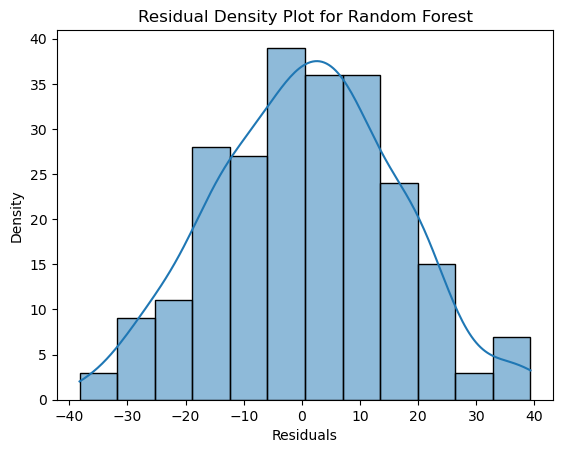

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
residuals = y_test - rf_preds

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Density Plot for Random Forest')
plt.show()


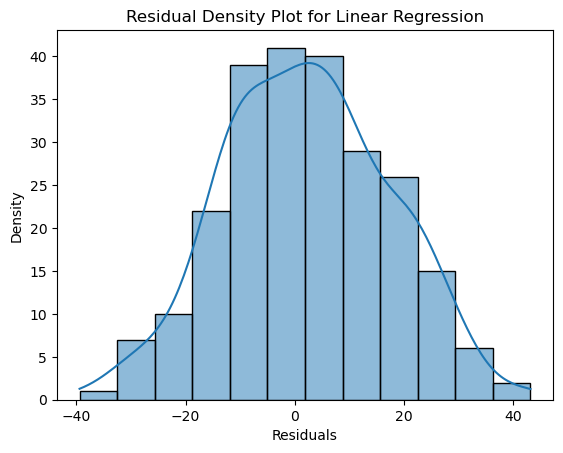

In [49]:
residuals = y_test - linear_reg_preds

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Density Plot for Linear Regression')
plt.show()

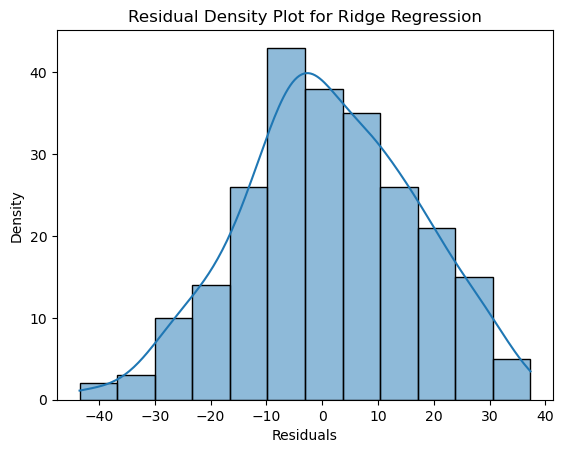

In [50]:
residuals = y_test - ridge_reg_preds

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Density Plot for Ridge Regression')
plt.show()

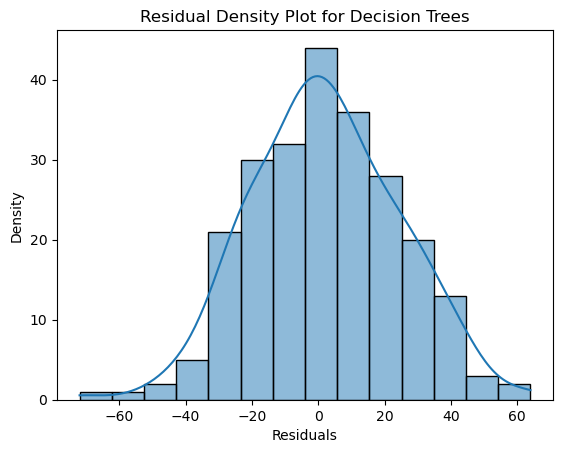

In [51]:
residuals = y_test - tree_preds

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Density Plot for Decision Trees')
plt.show()

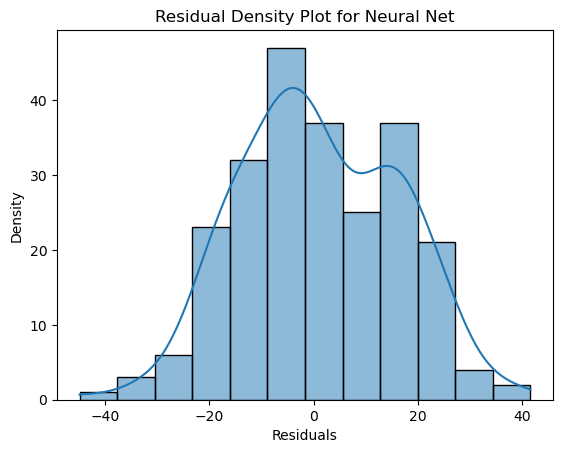

In [64]:
residuals_neural_net = y_test - neural_net_preds

sns.histplot(residuals_neural_net, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Density Plot for Neural Net')
plt.show()